<a href="https://colab.research.google.com/github/GLopezMUZH/Packing_and_Vehcicle_Routing/blob/main/L%26GV_Ex4_Part2_CW_wh_and_routes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ETHZ - IVT - Logistik und Güterverkehr SS2021
# Assignment 4: Operating a logistics system - Part2 - Vehicle Routing and Facility Location

* Gabriela López Magaña
* Alexander Hoz
* Jackson Buckner
01.06.2021

In [1]:
from scipy.io import loadmat
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
from operator import itemgetter
from copy import deepcopy
import sys

In [2]:
sys.setrecursionlimit(15000) # > len(savings)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Data and visualisation functions

In [6]:
def get_distance(n1, n2):
    # Euclideian
    dist = 0 
    dist = sqrt(((n1.pos.x - n2.pos.x) ** 2) + ((n1.pos.y - n2.pos.y) ** 2))
    return dist

In [7]:
def plot_clients(G, pos_dict, fig_size=15):
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    plt.title('Client locations')
    nx.draw(G, pos=pos_dict, with_labels = True, node_color='lightblue',node_size=500,edgelist=[],ax=ax)
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

    plt.grid(True, which='both')

    plt.show()

In [8]:
def get_graph_data(clients_array):

    columns = ['client_id','client_x', 'client_y','client_demand']
    clients_df = pd.DataFrame(clients_array, columns=columns)
    client_coordinates = clients_df[['client_x','client_y']].values.tolist()

    client_names = np.arange(0, len(client_coordinates), 1)
    G = nx.Graph() 
    G.add_nodes_from(client_names)

    # %%
    i=0
    pos_dict = {}
    for c_l in client_coordinates:
        #print(c_l)
        pos_dict[i] = c_l
        for j in range(1, G.number_of_nodes()):
            if not (i == j):
                dist = np.sqrt( (c_l[0] - client_coordinates[j][0])**2 + (c_l[1] - client_coordinates[j][1])**2 )
                #print(str(i) + " -> " + str(j) + ":" + str(dist)) # prints the distance between the two nodes
                G.add_edge(i,j,weight=dist, length=dist)
        i += 1
    return G, pos_dict


# WH Location functions

In [9]:
def get_location_in_geometric_mean(client_coordinates_list):
    columns = ['client_x', 'client_y']
    clients_df = pd.DataFrame(client_coordinates_list, columns=columns)
    # get geometric mean
    wh_location = (sum(clients_df.client_x) / len(clients_df), sum(clients_df.client_y) / len(clients_df))
    print(wh_location)
    #print(round(wh_location[0],2), ', ', round(wh_location[1],2))
    return wh_location

# Clarke-Wright functions

In [10]:
# clients_array = [id, x, y, demand]
def set_CW_data(clients_array, capacity, correction_factor_euclidean_distance=1):
    global routes, savings, node_to_route, vehicleCapacity, customers

    customer_count = len(clients_array)
    #k_ = 5 #int(numbers[1])
    #vehicleCount = 5 #int(numbers[1])
    assigned = [-1] * customer_count
    vehicleCapacity = capacity
    print('customer_count: ', customer_count)
    print('vehicleCapacity: ', vehicleCapacity)


    customers = clients_array # client_id, x_cood, y_coord, demand
    routes = []
    node_to_route = []
    savings = []


    # initialize one route per customer
    for i in range(0, customer_count):
        routes.append([0, i, 0])

    # initialize node to route map
    node_to_route = [[0, i, 0] for i in range(0, customer_count)]

    # initiaize customer_count x customer_count distances array
    distances = [[0 for x in range(customer_count)] for y in range(customer_count)]

    # calculate distances
    for i in range(0, customer_count):
        for j in range(0, customer_count):
                distances[i][j] = math.sqrt((customers[i][1] - customers[j][1])**2 + (customers[i][2] - customers[j][2])**2) * correction_factor_euclidean_distance
    

    # calculate savings
    for i in range(1, customer_count):
        for j in range(i + 1, customer_count):
            if not i == j:
                sv = distances[0][i] + distances[0][j] - distances[i][j]
            else:
                sv = 0
            savings.append([[i, j], sv])

    # sort saving descending order
    savings = sorted(savings, key=itemgetter(1), reverse=True)

    return distances, savings

In [12]:
# Code based on https://github.com/Yilkici/Clarke_Wright_Algorithm_Python/blob/master/clarke_wright.py
def combine_routes(n1, n2, r1, r2, opt):
    newR = []

    if r1 == r2:
        #print("routes are equal")
        return r1

    # both nodes are not in modified route
    if opt == 0:
        newR = [0, n1, n2, 0]
    # one node exists in modified route
    elif opt == 1:
        # is end node of route
        if r2[-2] == n2:
            newR = newR + r2[0:-1]
            newR = newR + [n1, 0]
        # is begining of route
        if r2[1] == n2:
            newR = newR + [0, n1]
            newR = newR + r2[1:]
    # both nodes exist in modified route
    else:
        # both are start nodes
        if r1[1] == n1 and r2[1] == n2:
            rev_r1 = r1[::-1]
            newR = newR + rev_r1[:-1]
            newR = newR + r2[1:]
        # n1 is start node, n2 is end node
        elif r1[1] == n1 and r2[-2] == n2:
            newR = newR + r2[0:-1]
            newR = newR + r1[1:]
        # n1 ist end node, n2 ist start node
        elif r1[-2] == n1 and r2[1] == n2:
            newR = newR + r1[0:-1]
            newR = newR + r2[1:]
        else:
            # both are end nodes
            rev_r2 = r2[::-1]
            newR = newR + r1[0:-1]
            newR = newR + rev_r2[1:]

    return  newR

def compute_tot_demand(r):
    demands = [customers[i][3] for i in r[1:-1]]
    return  sum(demands)

def is_external(n, r):
    if r[-2] == n or r[1] == n:
        return True
    return False

def print_CW_routes_for_customers():
    for i in range(0, len(customers)):
        print("route for customer ", i, " ", node_to_route[i])

In [13]:
def get_CW_graph(do_print=False):
    n_t_r = sorted(node_to_route)
    uniqueList = []
    color_table = ['blue', 'yellow', 'lavender', 'lightblue', 'darkblue', 'magenta', 'orange', 'yellowgreen','indigo']
    customer_count = len(customers)
    total_distance = 0

    for route in n_t_r:
        if route not in uniqueList:
            uniqueList.append(route)

    if do_print:
        print("number of routes: ", len(uniqueList))
    
    color_map = [0]*customer_count
    client_names = np.arange(0, customer_count-1, 1)
    G2 = nx.Graph() 
    G2.add_nodes_from(client_names)

    prev_node = 0
    idx_color = -1
    for route in uniqueList: 
        route_lengt = 0
        idx_color += 1
        for node in route:
            """
            print('prev_node: ', prev_node)
            print('node: ', node)
            print('dist: ', distances[prev_node][node])
            """
            color_map[node] = color_table[idx_color]
            dist = distances[prev_node][node]
            route_lengt += dist
            if prev_node != node:
                #print("add edge i, j:", prev_node, node)
                G2.add_edge(prev_node,node,weight=dist, length=dist)
            prev_node = node
        if do_print:
            print("length: ", route_lengt, ", steps: ", len(route), ", route: ", route)
        total_distance += route_lengt

    print("total distance: ", total_distance)

    return G2, color_map, uniqueList

In [14]:
def draw_graph_paths(G2, clients_array, color_map, fig_size=15):
    columns = ['client_id','client_x', 'client_y','client_demand']
    clients_df = pd.DataFrame(clients_array, columns=columns)
    client_coordinates = clients_df[['client_x','client_y']].values.tolist()

    pos_dict2 = { i : clients_df[['client_x','client_y']].values.tolist()[i] for i in range(0, len(clients_df) ) }

    #print(color_map)

    e_labels = {e: round(G2.edges[e]['weight'],ndigits=1) for e in G2.edges}

    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    #plt.title('Client locations')
    nx.draw(G2, pos=pos_dict2, with_labels = True, node_color=color_map,node_size=1000,ax=ax)
    nx.draw_networkx_edge_labels(G, pos=pos_dict2, edge_labels=e_labels)
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    plt.grid(True, which='both')
    plt.show()

In [15]:
# 3 - CW loop over savings 
# Code based on https://github.com/Yilkici/Clarke_Wright_Algorithm_Python/blob/master/clarke_wright.py
def CW():

    if len(savings) == 0:
        #print("Error Savings is empty")
        return

    chosen = savings[0]
    savings.remove(chosen)
    n1 = chosen[0][0]
    n2 = chosen[0][1]

    r1 = node_to_route[n1]
    r2 = node_to_route[n2]

    #breakpoint()

    #if (int(n1) == 23):
    #print("n1: ", n1, ", n2: ", n2)
    #print("r1: ", r1)
    #print("r2: ", r2)


    # first attempt on both routes
    if len(r1) == 3 and len(r2) == 3:
        new_r = combine_routes(n1, n2, r1, r2, 0)
        if compute_tot_demand(new_r) <= vehicleCapacity:
            for i in range(0, len(new_r)):
                node = new_r[i]
                node_to_route[node] = new_r
    # r2 was already modified
    if len(r1) == 3 and len(r2) > 3:
        if is_external(n2, r2):
            new_r = combine_routes(n1, n2, r1, r2, 1)
            if compute_tot_demand(new_r) <= vehicleCapacity:
                for i in range(0, len(new_r)):
                    node = new_r[i]
                    node_to_route[node] = new_r
    # r1 was already modified
    if len(r1) > 3 and len(r2) == 3:
        if is_external(n1, r1):
            new_r = combine_routes(n2, n1, r2, r1, 1)
            if compute_tot_demand(new_r) <= vehicleCapacity:
                for i in range(0, len(new_r)):
                    node = new_r[i]
                    node_to_route[node] = new_r
    # both routes have been modified
    if len(r1) > 3 and len(r2) > 3:
        if is_external(n1, r1) and is_external(n2, r2):
            new_r = combine_routes(n1, n2, r1, r2, 2)
            if compute_tot_demand(new_r) <= vehicleCapacity:
                for i in range(0, len(new_r)):
                    node = new_r[i]
                    node_to_route[node] = new_r

    CW()

# Data Ex **4**

In [16]:
file1_dir_path = '/content/gdrive/MyDrive/UZH_varios/ETH_L&GV_Ex4/inputDataAssignment.mat'
file1_dict = loadmat(file1_dir_path)

In [17]:
M_val = file1_dict.get("M")[0][0]
C_list = [[element for element in upperElement] for upperElement in file1_dict['C']]
nr_clients = len(C_list)
print("Truck capacity: ",M_val)
print("Number of clients: ", len(C_list))

Truck capacity:  35
Number of clients:  155


## Get Warehouse Location, use gemoetric mean

In [20]:
wh_location = get_location_in_geometric_mean(C_list)

(37.6912454268771, 38.92380135992632)


# Vehicle Routing

In [19]:
# convert list to array
C_arr = np.asarray(C_list)

# set demands of each client to 1
dem = [1]*nr_clients
# set the id of the clients in the array
clt_ids = np.arange(1,nr_clients+1,1)
# transform to numpy arrays
id_nr_arr = np.array(clt_ids, dtype= int)
dem_arr = np.array(dem, dtype = int)

# create numpy array with structure [id, xcoord, ycoord, demand]
clt_arr = np.hstack((id_nr_arr[:, None], C_arr, dem_arr[:, None]))

# set warehouse values
warehouse = [] #[client_id=0, 30.0, 40.0, demand=0]
warehouse = [0,round(wh_location[0],2), round(wh_location[1],2), 0]
customers = []

In [ ]:
# add Warehouse as the first row i array (index = 0)
clt_arr_n = np.vstack((warehouse,clt_arr))
clt_arr = []
clt_arr = clt_arr_n
print(len(clt_arr))
print(clt_arr[:10])
print("...")
print(clt_arr[-10:])

156
[[ 0.         37.69       38.92        0.        ]
 [ 1.         11.88696591 21.95590303  1.        ]
 [ 2.         44.49827058 74.37612101  1.        ]
 [ 3.          1.89418286 45.91117423  1.        ]
 [ 4.         83.42137859 69.78801431  1.        ]
 [ 5.         72.78616146 49.806501    1.        ]
 [ 6.          1.32167031 63.7833997   1.        ]
 [ 7.         15.50527049 45.15401159  1.        ]
 [ 8.         29.22159454 67.06690021  1.        ]
 [ 9.         11.52772234 49.49064519  1.        ]]
...
[[146.           9.43401034  49.92307666   1.        ]
 [147.          27.32318494  44.9175028    1.        ]
 [148.          10.99669932  45.57047952   1.        ]
 [149.          13.00776982  35.2416045    1.        ]
 [150.          15.36878077  47.12147555   1.        ]
 [151.          28.16659432  59.90260276   1.        ]
 [152.           0.92847019  54.50505326   1.        ]
 [153.          21.50635991  47.83117871   1.        ]
 [154.          26.73056863  59.27967205 

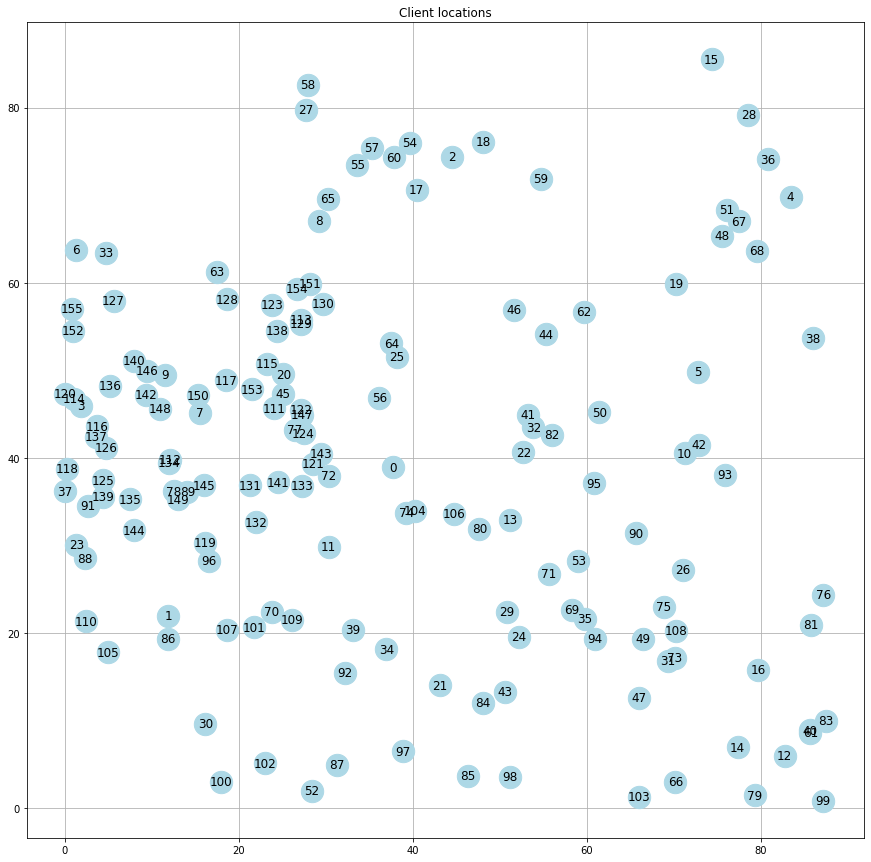

In [ ]:
G, pos_dict = get_graph_data(clt_arr_n)
plot_clients(G, pos_dict,15)

## Apply CW to Ex 4

In [ ]:
distances, savings = set_CW_data(clt_arr, M_val)

customer_count:  156
vehicleCapacity:  35


In [ ]:
CW()

In [ ]:
#print_CW_routes_for_customers()

In [ ]:
G2, color_map, unique_routes = get_CW_graph(True)

number of routes:  5
length:  197.0579689609678 , steps:  37 , route:  [0, 39, 92, 34, 21, 43, 84, 98, 85, 97, 87, 52, 102, 100, 30, 107, 101, 70, 109, 134, 112, 148, 142, 146, 9, 150, 7, 117, 153, 115, 20, 45, 111, 122, 147, 77, 0]
length:  234.46755519515273 , steps:  37 , route:  [0, 41, 32, 82, 50, 95, 71, 53, 90, 10, 42, 93, 26, 75, 108, 31, 73, 16, 76, 81, 83, 40, 61, 99, 12, 79, 14, 66, 103, 47, 49, 94, 35, 69, 24, 29, 0]
length:  269.3642209468609 , steps:  37 , route:  [0, 46, 44, 62, 19, 5, 38, 68, 48, 51, 67, 4, 36, 28, 15, 59, 18, 2, 60, 54, 57, 58, 27, 55, 65, 8, 17, 130, 151, 154, 123, 63, 128, 138, 113, 129, 0]
length:  91.72976389795093 , steps:  17 , route:  [0, 72, 143, 124, 121, 133, 11, 74, 104, 106, 80, 13, 22, 25, 64, 56, 0]
length:  166.78630749926526 , steps:  37 , route:  [0, 132, 119, 96, 1, 86, 105, 110, 88, 23, 91, 37, 118, 137, 116, 3, 114, 120, 152, 155, 6, 33, 127, 140, 136, 126, 125, 139, 135, 144, 78, 149, 89, 145, 131, 141, 0]
total distance:  959.4058

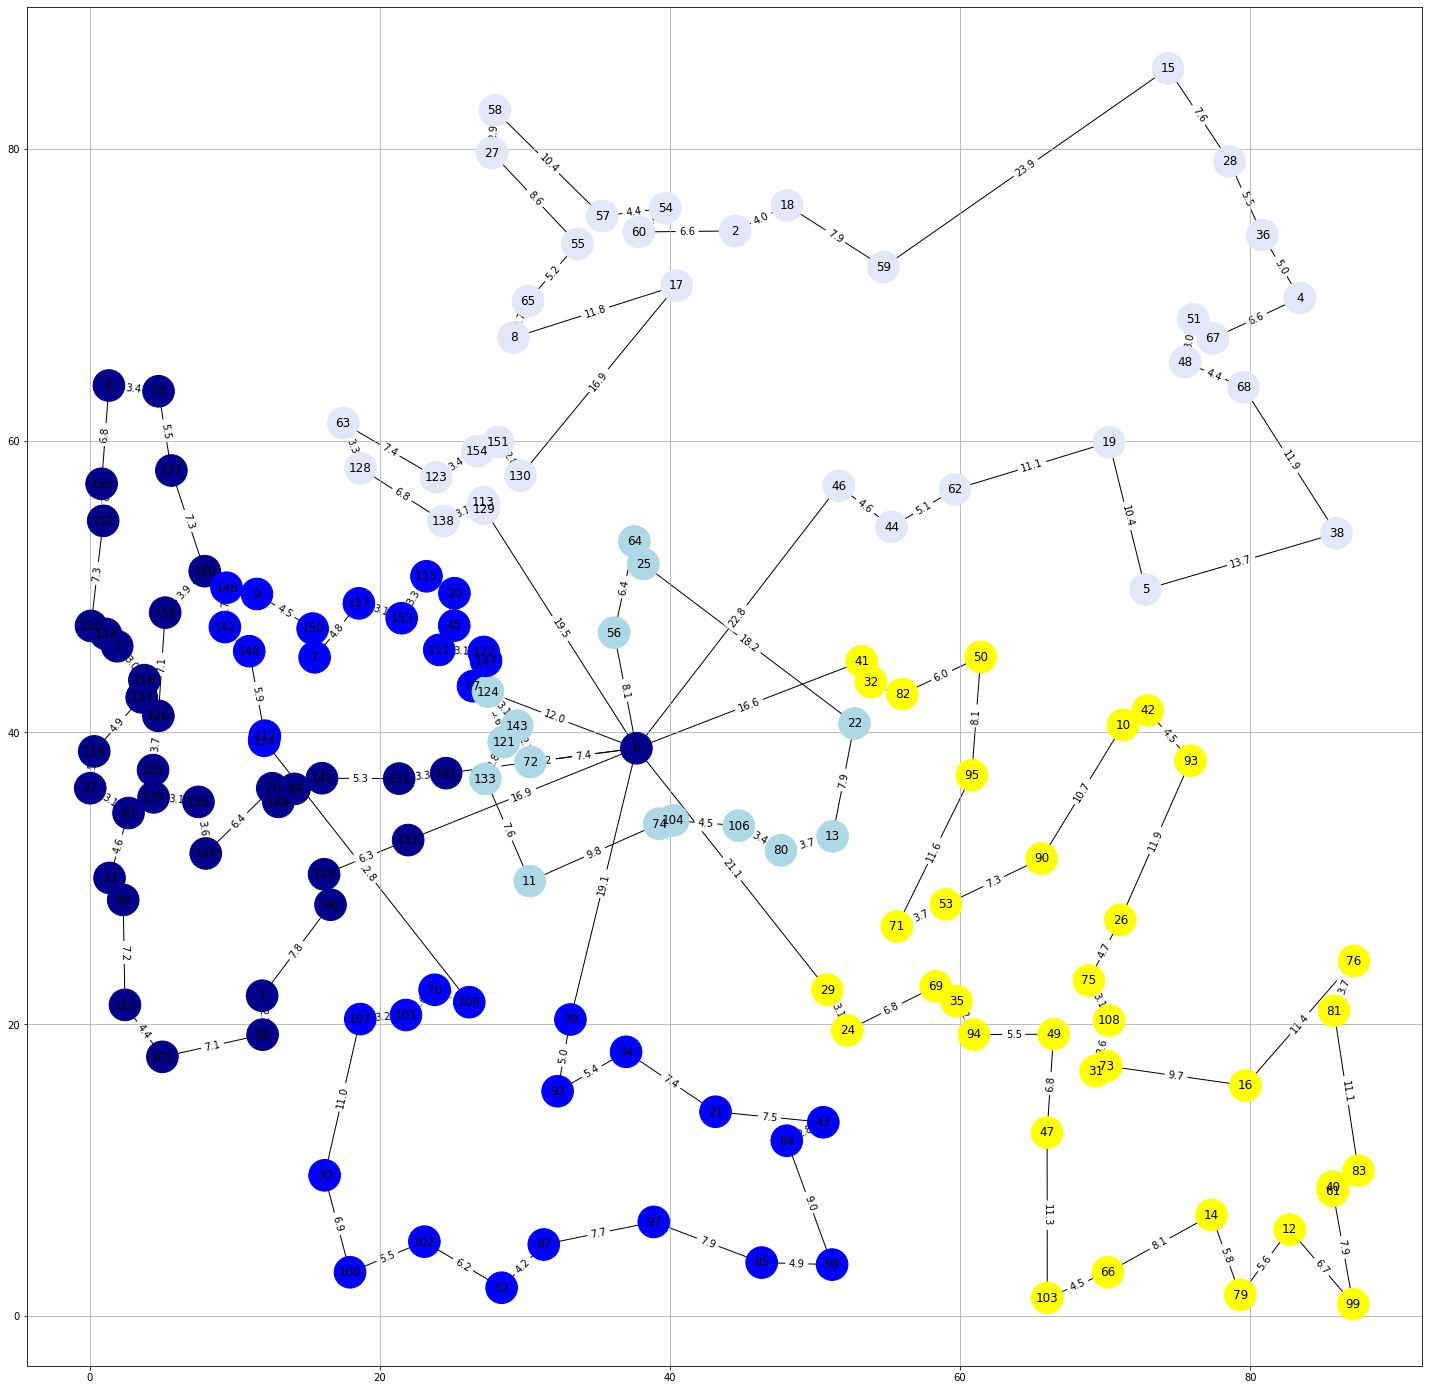

In [ ]:
draw_graph_paths(G2, clt_arr, color_map, 25)

In [ ]:
def 2_opt_swapping(routes):
    for route in routes:
        route_length = 
        idx_n1 = random.randint(0,len(route))
        idx_n2 = random.randint(0,len(route))
        if idx_n1 != idx_n2:



In [ ]:
#print(unique_routes)
transformed_routes = np.zeros(shape=(len(unique_routes),(M_val+2)))

idx_route = 0
for r in unique_routes:
    print(len(r))
    idx_node = 0
    for n in r:
        if n == 0:
            transformed_routes[idx_route][idx_node] = 156
        else:
            transformed_routes[idx_route][idx_node] = n
        idx_node += 1
    if len(r) < M_val+2:
        for idx in range(M_val+2-len(r),(M_val+2)):
            transformed_routes[idx_route][idx] = 0
    idx_route += 1


np.set_printoptions(linewidth=np.inf)
for nr in transformed_routes:
    print(nr)

37
37
37
17
37
[156.  39.  92.  34.  21.  43.  84.  98.  85.  97.  87.  52. 102. 100.  30. 107. 101.  70. 109. 134. 112. 148. 142. 146.   9. 150.   7. 117. 153. 115.  20.  45. 111. 122. 147.  77. 156.]
[156.  41.  32.  82.  50.  95.  71.  53.  90.  10.  42.  93.  26.  75. 108.  31.  73.  16.  76.  81.  83.  40.  61.  99.  12.  79.  14.  66. 103.  47.  49.  94.  35.  69.  24.  29. 156.]
[156.  46.  44.  62.  19.   5.  38.  68.  48.  51.  67.   4.  36.  28.  15.  59.  18.   2.  60.  54.  57.  58.  27.  55.  65.   8.  17. 130. 151. 154. 123.  63. 128. 138. 113. 129. 156.]
[156.  72. 143. 124. 121. 133.  11.  74. 104. 106.  80.  13.  22.  25.  64.  56. 156.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
[156. 132. 119.  96.   1.  86. 105. 110.  88.  23.  91.  37. 118. 137. 116.   3. 114. 120. 152. 155.   6.  33. 127. 140. 136. 126. 125. 139. 135. 144.  78. 149.  89. 145. 131. 141. 156.]


## 2 Opt

In [4]:
class Position:

    def __init__(self,x,y):
        self.x = x
        self.y = y      

    def __str__(self):
        return "(" + str(self.x) + ", " + str(self.y) + ") "

    def x_coor(self):
        return self.x

    def y_coor(self):
        return self.y

In [21]:
class Client_node:

    pos = Position(-1,-1)
    demand = 1

    def __init__(self, id, x, y):
        self.id = id

    def __init__(self, id):
        self.id = id

    def setPosition(self, x, y):
        self.pos = Position(x, y)

    def setDemand(self,d):
        self.demand = d

    def setAngleWithWarehouse(self, a):
        self.angleWithWarehouse = a

    def __str__(self):
        return str(self.id) + " -> (" + str(self.pos.x) + ", " + \
                str(self.pos.y) + ") -> " + str(self.demand)
        #return "(" + str(self.pos.x) + ", " + \
        #           str(self.pos.y) + " )"

In [ ]:
"""
Class Route:
    def __init__(self,node_list):
        self.node_list = node_list

    def __str__(self):
        return "(" + str(self.x) + ", " + str(self.y) + ") "

    def get_length(self):
        prev_node = 0
        first = True
        route_lengt = 0
        for node in self.node_list:
            if !first:
                dist = get_distance(prev_node,node)
                route_lengt += dist
            else:
                first = False
            prev_node = node
        return route_lengt
"""

'\nClass Route:\n    def __init__(self,node_list):\n        self.node_list = node_list\n\n    def __str__(self):\n        return "(" + str(self.x) + ", " + str(self.y) + ") "\n\n    def get_length(self):\n        prev_node = 0\n        first = True\n        route_lengt = 0\n        for node in self.node_list:\n            if !first:\n                dist = get_distance(prev_node,node)\n                route_lengt += dist\n            else:\n                first = False\n            prev_node = node\n        return route_lengt\n'

# Example from class

In [ ]:
clt_arr = np.array([
[0, 0, 0 , 0],
[1, 14, 40, 3],
[2, 10, 83, 2.7],
[3, 27, 60, 0.9],
[4, 67, 80, 1.2],
[5, 80, 57, 0.8],
[6, 90, 93, 2.6]])

In [ ]:
print(clt_arr)

[[ 0.   0.   0.   0. ]
 [ 1.  14.  40.   3. ]
 [ 2.  10.  83.   2.7]
 [ 3.  27.  60.   0.9]
 [ 4.  67.  80.   1.2]
 [ 5.  80.  57.   0.8]
 [ 6.  90.  93.   2.6]]


In [ ]:
M_val = 6
correction_factor_euclidean_distance = 1.2
wh_location = [0,0]

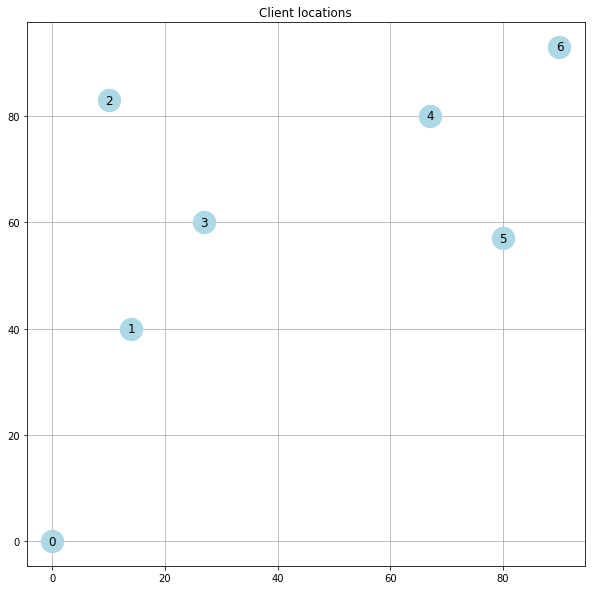

In [ ]:
G, pos_dict = get_graph_data(clt_arr)
plot_clients(G, pos_dict,10)

## Apply CW

In [ ]:
distances, savings = set_CW_data(clt_arr, M_val, correction_factor_euclidean_distance)

customer_count:  7
vehicleCapacity:  6


In [ ]:
print((distances[0]))
print((distances[1]))
print((distances[2]))
print((distances[3]))
print((distances[4]))
print((distances[5]))
print((distances[6]))

[0.0, 50.85508824100102, 100.32028708092895, 78.9541639180607, 125.22044561492343, 117.8751882289059, 155.30151319288552]
[50.85508824100102, 0.0, 51.82277491605404, 28.624465060503752, 79.68036144496334, 81.78508421466593, 111.18633009502561]
[100.32028708092895, 51.82277491605404, 0.0, 34.32083915058022, 68.49467132558561, 89.60714257245345, 96.74709297958259]
[78.9541639180607, 28.624465060503752, 34.32083915058022, 0.0, 53.665631459994955, 63.701805311937584, 85.34354105613382]
[125.22044561492343, 79.68036144496334, 68.49467132558561, 53.665631459994955, 0.0, 31.703627552694975, 31.703627552694975]
[117.8751882289059, 81.78508421466593, 89.60714257245345, 63.701805311937584, 31.703627552694975, 0.0, 44.83570006144657]
[155.30151319288552, 111.18633009502561, 96.74709297958259, 85.34354105613382, 31.703627552694975, 44.83570006144657, 0.0]


In [ ]:
savings

[[[4, 6], 248.818331255114],
 [[5, 6], 228.34100136034488],
 [[4, 5], 211.39200629113435],
 [[2, 6], 158.87470729423188],
 [[2, 4], 157.04606137026678],
 [[3, 4], 150.50897807298918],
 [[3, 6], 148.91213605481244],
 [[2, 3], 144.95361184840945],
 [[3, 5], 133.127546835029],
 [[2, 5], 128.5883327373814],
 [[1, 3], 101.18478709855796],
 [[1, 2], 99.35260040587593],
 [[1, 4], 96.39517241096111],
 [[1, 6], 94.97027133886094],
 [[1, 5], 86.945192255241]]

In [ ]:
CW()

In [ ]:
print_CW_routes_for_customers()

route for customer  0   [0, 1, 2, 0]
route for customer  1   [0, 1, 2, 0]
route for customer  2   [0, 1, 2, 0]
route for customer  3   [0, 3, 4, 6, 5, 0]
route for customer  4   [0, 3, 4, 6, 5, 0]
route for customer  5   [0, 3, 4, 6, 5, 0]
route for customer  6   [0, 3, 4, 6, 5, 0]


In [ ]:
G2, color_map, uniqueList = get_CW_graph(True)

number of routes:  2
length:  202.99815023798402 , steps:  4 , route:  [0, 1, 2, 0]
length:  327.03431122110305 , steps:  6 , route:  [0, 3, 4, 6, 5, 0]
total distance:  530.032461459087


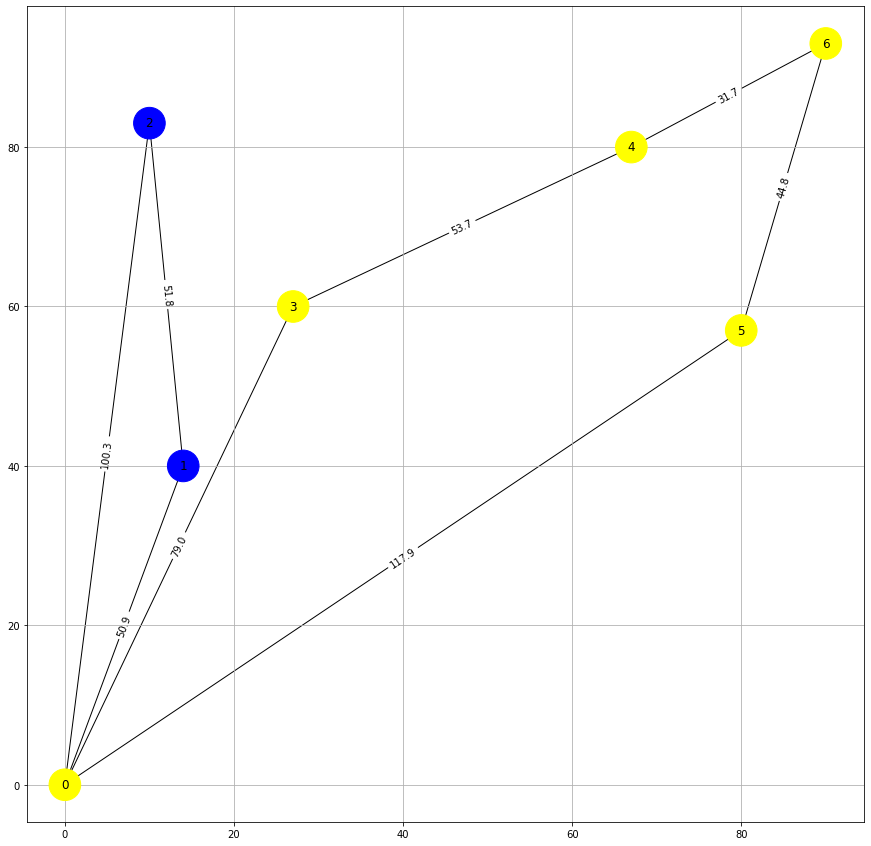

In [ ]:
draw_graph_paths(G2, clt_arr, color_map)